In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import joblib
import itertools

import utils

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import seaborn as sns
plt.style.use('seaborn-whitegrid')

import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier


from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.over_sampling  import SMOTE

from collections import Counter


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



### Get Training, Validation, Balanced sets 

##### NOTE: the "training_sets" contains the sets of training and validation to help the models execution, with the following information:
 - `Dataset Info `  ["Training", "Training Balanced"]
 - `Features Info`  ["All Features", "Feature Selection"]
 - `"X" to train`   
 - `"y" to train` 
 - `"X" to validation`


In [2]:
X_train, X_train_fs, y_train, \
X_train_balanced, X_train_fs_balanced, y_train_balanced,\
X_valid, X_valid_fs, y_valid, training_sets = utils.get_train_and_validation_data(
    return_training_sets=True
)


X_all = pd.concat([X_train, X_valid])
X_all_fs = pd.concat([X_train_fs, X_valid_fs])
y_all = np.concatenate((y_train, y_valid))


display(X_train)


,Diagnosis_Delay,Age_Range_at_Onset,Riluzole,Sex_Male,Site_Onset,FVC,BMI,Q1_Speech_slope,Q2_Salivation_slope,Q3_Swallowing_slope,Q4_Handwriting_slope,Q5_Cutting_slope,Q6_Dressing_and_Hygiene_slope,Q7_Turning_in_Bed_slope,Q8_Walking_slope,Q9_Climbing_Stairs_slope,Q10_Respiratory_slope,Qty_Regions_Involved,Region_Involved_Bulbar,Region_Involved_Upper_Limb,Region_Involved_Lower_Limb,Region_Involved_Respiratory,Patient_with_Gastrostomy
0,1.0,0.50,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.0,1.0,1.0,0.0,0.0
1,0.5,0.75,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
2,1.0,0.25,0.0,1.0,1.0,0.0,0.50,0.5,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
3,0.5,0.50,0.0,0.0,0.0,1.0,1.00,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.75,1.0,0.0,1.0,1.0,0.0
4,0.0,0.75,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,0.5,0.50,0.0,0.0,0.0,1.0,0.50,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,1.0
1569,0.5,0.50,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0
1570,1.0,0.50,0.0,1.0,1.0,0.0,1.00,0.5,0.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,1.0,0.0,1.0,0.0
1571,1.0,0.75,1.0,1.0,1.0,1.0,0.50,0.0,0.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.00,1.0,1.0,1.0,1.0,0.0


Column: y  (DataType: object)
N         = 1967 [Non-NaN: 1967]
Missingness: 0 (0.0%)

Summary Table:
     count percentage
NO    1717     87.29%
YES    250     12.71%


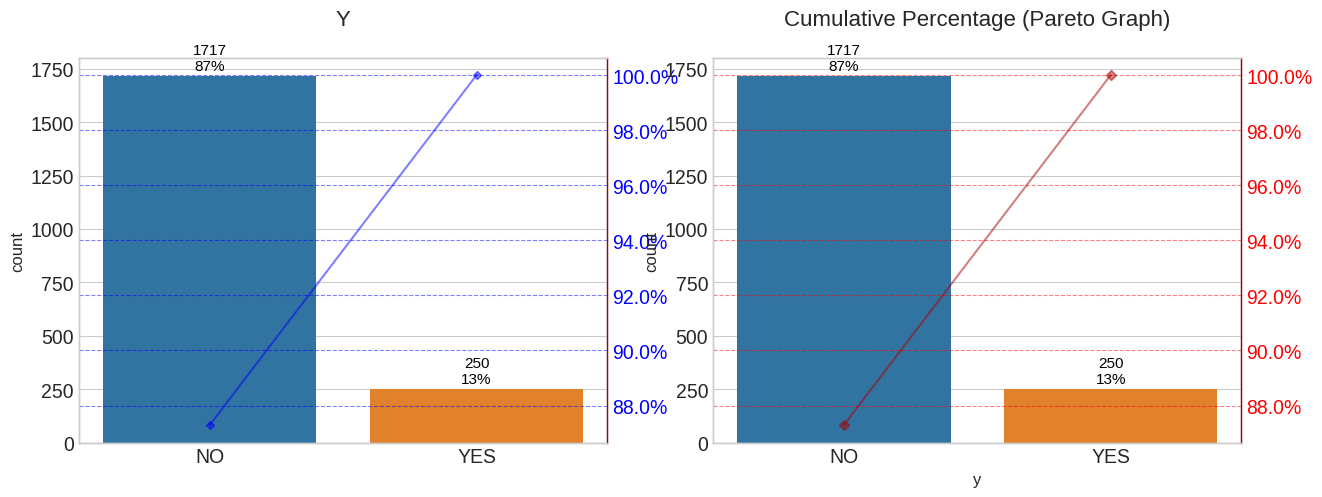

In [5]:
utils.plot_variable_distribution(pd.Series(y_all, name='y'))

---
## Read results CSV file and get all unique $Model+Hyperparameters$
#### NOTE: DO NOT re-execute all models, see `classif_filtered` variable

In [91]:
%%time

# get a Set of models from the results CSV without repeating
dir_dest = os.path.abspath('exec_results/')

results_csv_file = f'{dir_dest}/results.csv'
classifiers = utils.get_models_set_from_results(results_csv_file=results_csv_file)


# ==================================================================
# remove some time consuming Classifiers 
# ==================================================================
# classif_filtered = []
# 
# for clf in classifiers:
#     to_exec = ('catboost' not in str(clf)) \
#           and ('XGB'      not in str(clf))
#     if to_exec:
#         classif_filtered.append(clf)
# 
# classifiers = classif_filtered.copy()        
# ==================================================================

        
# ==================================================================
# Keep only SVM, i.e., only the SVM will be executed
# ==================================================================
# classif_filtered = []

# for clf in classifiers:
#     to_exec = ('SVC' in str(clf))
#     if to_exec:
#         classif_filtered.append(clf)

# classifiers = classif_filtered.copy()        
# ==================================================================
        

# ==================================================================
# Keep only RandomForest, i.e., only the RF will be executed
# ==================================================================
classif_filtered = []

for clf in classifiers:
    to_exec = ('RandomForest' in str(clf))
    if to_exec:
        classif_filtered.append(clf)

classifiers = classif_filtered.copy()        
# ==================================================================
        
        

print(len(classifiers))
print(classifiers[:5])


96
[RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=42), RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=200, random_state=42), RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=50, random_state=42), RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=75, random_state=42), RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, random_state=42)]
CPU times: user 255 ms, sys: 3.75 ms, total: 259 ms
Wall time: 258 ms


### Execute each $Model+Hyperparameters$ using $Balanced$ $Bagging$ model, using GridSearch

In [97]:
%%time

# verify if already exists an CSV with the results
overwrite_results_saved_previously = False

csv_results_saved = f'{dir_dest}/results_imbalance_learning.csv'
if os.path.exists(csv_results_saved) and overwrite_results_saved_previously==False:
    print('Reading results saved previously...')
    df_results = utils.read_csv(csv_file=csv_results_saved)
else:
    df_results = None


## define the models and hyperparameters for the GridSearch
testing=False


if len(classifiers) > 0:

    kfold = utils.get_kfold_splits()

    qty_at_time = 1

    # execute GridSearch using "qty_at_time" classifiers at a time
    for i in range(0, len(classifiers), qty_at_time):
        # get first/next "n" classifiers
        classifiers_to_exec = classifiers[i:i+qty_at_time]
        
        param_grid = []
        _ = utils.create_models_BalancedBagging_grid(
            classifiers=classifiers_to_exec,
            param_grid=param_grid, 
            testing=testing
        )

        ## execute GridSearch
        grid, df_results_aux = utils.exec_grid_search(
            param_grid=param_grid, 
            X=X_valid, 
            y=y_valid,
            cv=kfold,
            verbose=1,
            return_train_score=True,
            sort_results=False,
            dataset_info='Imbalanced',
            features_info='All Features',
        )

        if df_results is None:
            df_results = df_results_aux
        else:
            df_results = pd.concat([df_results, df_results_aux])

        clear_output()
   
        df_to_save = utils.sort_performances_results(df_results)
        utils.save_to_csv(df=df_to_save, csv_file=csv_results_saved)

        time.sleep(30)
        

30210 samples were saved
CPU times: user 9min 53s, sys: 3.1 s, total: 9min 56s
Wall time: 7h 59min 12s


---

## Read the Ensemble+Imbalance results saved previously

In [33]:
csv_file = 'exec_results/results_imbalance_learning.csv'
df_results = utils.read_csv(csv_file=csv_file)

print(f'Qty results = {df_results.shape[0]}')

Qty results = 30210


## Get the best models ($BalAcc \ge 0.80$)and create instances using their hyperparameters¶

### Get the results and filter those with by $BalAcc \ge 0.80$

In [34]:
# filtering Bal Acc >= 0.80
threshold = 0.80
df_best = df_results.loc[(
     (df_results.BalAcc >= threshold) 
)].copy()

# get short model description
df_best['Model'] = df_best.Model.apply(lambda x: utils.get_model_short_description(x))

# get the ensemble-estimator used by the BaggingEnsemble
ens_est_aux = df_best.Hyperparams.astype(str).str.split('(').str[0]
ens_est = []
for est in ens_est_aux:
    ens_est.append(utils.get_model_description(est.split(':')[1].strip()))

df_best['Ensemble_Estimator'] = ens_est


print(f'Qty results = {df_best.shape[0]}')
# display(df_best.head(2))
print(df_best.Ensemble_Estimator.unique())
print(df_best.Model.unique())


Qty results = 17540
['Neural Networks' 'SVM' 'Decision Tree' 'Random Forest' 'Naïve Bayes'
 'k-NN']
['Balanced Bagging']


In [35]:
df_best_by_model = df_best.copy()

df_best_by_model = df_best_by_model.groupby(
    by=['Ensemble_Estimator', 'Dataset', 'Features']
).head(20).reset_index(drop=True).sort_values(
    by=['BalAcc','Sens', 'Spec'],
    ascending=False,
).reset_index(drop=True)


best_models = []

df_best_models = None

for index, row in df_best_by_model.iterrows():
    
    model   = row.Model
    dataset = row.Dataset
    features = row.Features
    ensemble_estimator = row.Ensemble_Estimator
    classif = row.Classifier
    params  = row.Hyperparams

    performance_gridsearch = {
        'BalAcc': row.BalAcc,
        'Sens': row.Sens,
        'Spec': row.Spec,
        'f1': row.f1,
        'AUC': row.AUC,
        'Acc': row.Acc,
        'Prec': row.Prec,
        
    }
    
#     try:
#         params = params.replace('\n', '')
#         params_dict = ast.literal_eval(params)
#     except Exception as ex:
#         print(params)
#         print(f'<<ERROR>>: {ex}')
#         print()
#     klass = globals()[classif]
#     clf = klass(**params_dict)
#     best_models.append([model, dataset, features, clf, params, performance_gridsearch])
   
    # store best models into dataFrame
    data = {
        'Model': model,
        'Dataset': dataset,
        'Features': features,
        'Ensemble_Estimator': ensemble_estimator,
        #
        'BalAcc': row.BalAcc,
        'Sens': row.Sens,
        'Spec': row.Spec,
        'f1': row.f1,
        'AUC': row.AUC,
        'Acc': row.Acc,
        'Prec': row.Prec,
        'Classifier': classif,
        'Hyperparams': params,
        
    }

    if df_best_models is None:
        df_best_models = pd.DataFrame(data, index=[0])
    else:
        df_best_models = df_best_models.append(data, ignore_index=True)

        
# print(f'Qty. of Models: {len(best_models)}')
# print('Example:')
# display(best_models[:1][0])

# display(df_best_models)

csv_file = os.path.abspath(f'exec_results/best_models_imbalance_learning_with_performance_greater_than_80.csv')
utils.save_to_csv(df=df_best_models, csv_file=csv_file)

120 samples were saved


---
## Read the best models saved previously

In [164]:
csv_file = os.path.abspath(f'exec_results/best_models_imbalance_learning_with_performance_greater_than_80.csv')
df_best_models = utils.read_csv(csv_file=csv_file)
df_best_models.head(2)

,Model,Dataset,Features,Ensemble_Estimator,BalAcc,Sens,Spec,f1,AUC,Acc,Prec,Classifier,Hyperparams
0,Balanced Bagging,Imbalance,All Features,Neural Networks,0.88,0.89,0.88,0.65,0.93,0.88,0.52,BalancedBaggingClassifier,"{'estimator': MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,\n max_iter=1000, random_state=42, solver='sgd'), 'n_estimators': 50, 'random_state': 42, 'sampling_strategy': 'all', 'warm_start': False}"
1,Balanced Bagging,Imbalance,All Features,Neural Networks,0.88,0.89,0.88,0.65,0.93,0.88,0.52,BalancedBaggingClassifier,"{'estimator': MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,\n max_iter=1000, random_state=42, solver='sgd'), 'n_estimators': 50, 'random_state': 42, 'sampling_strategy': 'all', 'warm_start': True}"


### Get the ensemble-estimator (as string) used by the BaggingEnsemble


In [165]:
split_str =  ", 'n_estimators':"

# get the ensemble-estimator used by the BaggingEnsemble
est_aux = df_best_models.Hyperparams.astype(str).str.split(split_str).str[0]
estimators = []
for e_aux in est_aux:

    e = e_aux.split(': ')[1]
    est.append(e)

    # get model class name to create an instance after
    split_1 = e.split('(')
    classif = split_1[0]
    
    # separate the hyperparams
    ind = e.find('(')
    params = e[ind:]
    params = params.replace('\n', '')
    params = params[1:]
    params = params[:-1]
    
    try:
        if len(params) > 0:
            # convert model hyperparams to dic
            params_dict = utils.convert_hyperparams_to_dict(params)
        else:
            params_dict = {}
            
        # create an model instance passing the hyperparameters
        klass = globals()[classif]
        model = klass(**params_dict)

    except Exception as ex:
        print(e_aux)
        print(params)
        raise Exception(f'ERROR: {ex}')    
    
    
    estimators.append(model)


estimators   

[MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
               max_iter=1000, random_state=42, solver='sgd'),
 MLPClassifier(alpha=0.05, 

### Create instances for each best $Balanced\_Bagging$ model, using their hyperparameters

In [166]:
i = 0
split_str =  ", 'n_estimators':"

models_to_exec = []

for idx, row in df_best_models.iterrows():
    
    # get the ensemble-estimator used by the BaggingEnsemble
    other_params = "{'n_estimators':" + row.Hyperparams.split(split_str)[1]
    # convert to dict  
    other_params_dict = ast.literal_eval(other_params)

    # create model instance
    estimator = estimators[i]
    clf = resemb.BalancedBaggingClassifier(
        estimator=estimator,
        **other_params_dict
    )
    
    
    model   = row.Model
    dataset = row.Dataset
    features = row.Features
    classif = row.Classifier
    params  = row.Hyperparams

    performance_gridsearch = {
        'BalAcc': row.BalAcc,
        'Sens': row.Sens,
        'Spec': row.Spec,
        'f1': row.f1,
        'AUC': row.AUC,
        'Acc': row.Acc,
        'Prec': row.Prec,
        
    }
    
    
    models_to_exec.append([model, dataset, features, clf, params, performance_gridsearch, estimator])
    
    i += 1
    
print(len(models_to_exec))    

print(models_to_exec[:2])

120
[['Balanced Bagging', 'Imbalance', 'All Features', BalancedBaggingClassifier(estimator=MLPClassifier(alpha=0.05,
                                                  hidden_layer_sizes=(14,),
                                                  learning_rate_init=0.7,
                                                  max_iter=1000,
                                                  random_state=42,
                                                  solver='sgd'),
                          n_estimators=50, random_state=42,
                          sampling_strategy='all'), "{'estimator': MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,\n              max_iter=1000, random_state=42, solver='sgd'), 'n_estimators': 50, 'random_state': 42, 'sampling_strategy': 'all', 'warm_start': False}", {'BalAcc': 0.88, 'Sens': 0.89, 'Spec': 0.88, 'f1': 0.65, 'AUC': 0.93, 'Acc': 0.88, 'Prec': 0.52}, MLPClassifier(alpha=0.05, hidden_layer_sizes=(14,), learning_rate_init=0.7,
      

---
---
## Reexecute each best model as following:

 - ### $Create$ an model instance using the best hyperparameters
 - ### $Fit$ the model using the Training set
 - ### $Validate$ the model using the Validation set 
 
 
<img src="slides/figures/grid_search_workflow.png" width="45%" >

[https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation]

In [171]:
%%time


models_results = [] 

i = 1
tot = len(models_to_exec)



## For each best model:
#    1. Fit using using the Training data
#    2. Validate using the Validation data

for model_desc, dataset, features, clf, params, performance_grid, estimator in models_to_exec:

    # get the classifier name (without the parameters)
    classifier_name = clf.__class__.__name__ 

    
#     # Just for testing    
#     if features != 'All Features':
#         continue
#     if classifier_name != 'CatBoostClassifier':
#         continue
#     if len(models_results) > 2:
#         break     
    
    
    try:
        print(f'{i}/{tot}: Executing {model_desc} using "{dataset}" with "{features}"', 
              end='\r'
        )
        i += 1
        
        # get the correct X, y, and X_validation to be used on model execution
        X = X_train
        y = y_train
        
        # if found the correct data
        if X is not None:
            # fit using the traning set
            clf.fit(X, y)

            #predict using the validation set
            y_pred = clf.predict(X_valid)
            
            #get performance
            bal_acc, sens, spec, auc, acc, prec, f1 = utils.get_scores_from_predict(
                y_validation=y_valid, 
                y_pred=y_pred, 
            )
            
            # Store the Validation and Training performances
            performance_to_save = {
                'Model': model_desc,
                'Dataset': dataset,
                'Features': features,
                # Validation performance
                'Valid_BalAcc': bal_acc,
                'Valid_Sens'  : sens,
                'Valid_Spec'  : spec,
                'Valid_f1'    : f1,
                'Valid_AUC'   : auc,
                'Valid_Acc'   : acc,
                'Valid_Prec'  : prec,
                # Voting performance
                'Train_BalAcc': performance_grid['BalAcc'],
                'Train_Sens'  : performance_grid['Sens'],
                'Train_Spec'  : performance_grid['Spec'],
                'Train_f1'    : performance_grid['f1'],
                'Train_AUC'   : performance_grid['AUC'],
                'Train_Acc'   : performance_grid['Acc'],
                'Train_Prec'  : performance_grid['Prec'],
                #
                #
                'Classifier': classifier_name,
                'Hyperparams': params,
                'Estimator': str(estimator).split('(')[0],
            }
            #
            models_results.append(performance_to_save)
            
        else:
            raise Exception('"X" and "y" sets not found!')
            
            
    except Exception as ex:
        print(clf)
        display(X.head(3))
        raise ex
        

        
clear_output(wait=False)
       
# create a dataFrame to store the performances and sort them
df_validation_performance = pd.DataFrame(models_results)

df_validation_performance = utils.sort_performances_results(
    df=df_validation_performance,
    cols_order_to_sort=['Valid_BalAcc', 'Valid_Sens', 'Valid_Spec'],
)


# save validation performance
csv_file = os.path.abspath('exec_results/validation_results_imbalance_learning.csv')
utils.save_to_csv(
    df=df_validation_performance, 
    csv_file=csv_file
)

120 samples were saved
CPU times: user 4min 51s, sys: 1.71 s, total: 4min 52s
Wall time: 3min 36s


---
---
---
# OTHERS

In [135]:
for e_aux in est:
#     print(e_aux)

    # get model class name to create an instance after
    split_1 = e_aux.split('(')
    classif = split_1[0]
    
    # separate the hyperparams
    ind = e_aux.find('(')
    params = e_aux[ind:]
    params = params.replace('\n', '')
    params = params[1:]
    params = params[:-1]
    
    try:
        if len(params) > 0:
            # convert model hyperparams to dic
            params_dict = utils.convert_hyperparams_to_dict(params)
        else:
            params_dict = {}
            
        # create an model instance passing the hyperparameters
        klass = globals()[classif]
        model = klass(**params_dict)

    except Exception as ex:
        print(e_aux)
        print(params)
        raise Exception(f'ERROR: {ex}')    

    

#     best_models.append([model, dataset, features, clf, params, performance_gridsearch])
    

# print(est)    
# df_best_models['Estimator_Instance'] = est

# df_best_models['Estimator_Instance']

In [98]:
gc.collect()

2469

In [100]:
models_already_exec = df_imb.Hyperparams.astype(str).str.split('(').str[0]

models_already_executed = models_already_exec.unique()

for m in models_already_executed:
    print(m.split(':')[1].strip())

    
models_already_exec.value_counts()    

MLPClassifier
SVC
DecisionTreeClassifier
RandomForestClassifier
ComplementNB
KNeighborsClassifier
GaussianNB
RadiusNeighborsClassifier


{'estimator': MLPClassifier                17280
{'estimator': RadiusNeighborsClassifier     4320
{'estimator': SVC                           3360
{'estimator': RandomForestClassifier        2880
{'estimator': DecisionTreeClassifier        1080
{'estimator': KNeighborsClassifier           720
{'estimator': ComplementNB                   540
{'estimator': GaussianNB                      30
Name: Hyperparams, dtype: int64

In [72]:
df_rf = df_imb.loc[(df_imb.Hyperparams.str.contains('RandomForest'))].copy()

df_rf['params'] = df_rf.Hyperparams.str.replace('\n', '')

# display(df_rf)

executed = []
not_executed = []

for rf in classifiers[:1]:
    print(rf)
    
    search_str = str(rf)#.replace('\n', '')
    print(search_str)
    already_executed = df_rf.loc[(df_rf.Hyperparams.str.contains(search_str))==True].copy()
    
    print(already_executed)
    if already_executed.shape[0] == 0:
        not_executed.append(rf)
    else:    
        executed.append(rf)

        
print(len(not_executed))    
print(len(executed))    


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=42)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=42)
Empty DataFrame
Columns: [Dataset, Features, Model, BalAcc, Sens, Spec, f1, AUC, Acc, Prec, Classifier, Hyperparams, params]
Index: []
1
0


In [82]:
clasifs = utils.get_models_set_from_results(results_csv_file=results_csv_file)
dd = pd.DataFrame(clasifs, columns=['clf'])
dd['model'] = dd.clf.astype(str).str.split('(').str[0]
dd.model.value_counts()

MLPClassifier                                                  576
RadiusNeighborsClassifier                                      144
SVC                                                            112
RandomForestClassifier                                          96
XGBClassifier                                                   64
DecisionTreeClassifier                                          36
KNeighborsClassifier                                            24
ComplementNB                                                    18
<catboost.core.CatBoostClassifier object at 0x7efd5c439310>      1
GaussianNB                                                       1
<catboost.core.CatBoostClassifier object at 0x7efd55e48430>      1
<catboost.core.CatBoostClassifier object at 0x7efd5c2a69d0>      1
<catboost.core.CatBoostClassifier object at 0x7efd56383520>      1
<catboost.core.CatBoostClassifier object at 0x7efd5631a880>      1
<catboost.core.CatBoostClassifier object at 0x7efd5632f580>   